# How Toponymy Works

Toponymy can produce compelling desconstructions of large corpora into well named topics at a wide variety of resolutions -- from large scale themes, to fine grained sub-topics. This tutorial will walk you through how it achieves this through a combination of clustering, feature extraction, LLMs, and careful cleanup of initially generated topic names. To get started let's import some initial libraries, and then get start collecting a (small) dataset we can explore with.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from collections import Counter

/work/home/lmmcinn/.conda/envs/toponymy_docs/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


For our dataset we are going to use the category theory section of ArXiv -- all the papers tagged with ``math.CT`` as one of the categories they were deemed to fall under. To keep things simple we will work with just the titles of the papers, and we'll use a dataset that has embeddings and a data map pre-built. This should provide a good example, since we have a small enough dataset to work through quickly (only around 8500 items, and the text is just the relatively short title of the paper), but the dataset is still fairly complex, involving a lot of complex domain specific language that can be challenging to work through.

In [2]:
arxiv_ct_df = pd.read_parquet("hf://datasets/lmcinnes/arxiv_category_theory/data/train-00000-of-00001.parquet")
arxiv_ct_df

,date_created,title,categories,arxiv_id,year,embedding,data_map
0,2007-04-04 06:58:08,Generic representations of orthogonal groups: ...,math.AT math.CT,0704.0502,2007,"[-0.5840985178947449, 0.9819669723510742, -4.2...","[11.470277786254883, 10.948436737060547]"
1,2007-04-11 09:08:03,Triangulated categories without models,math.AT math.CT math.KT,0704.1378,2007,"[0.13958382606506348, 1.518001675605774, -4.65...","[13.929526329040527, 10.156951904296875]"
2,2007-04-12 17:21:24,Complete Segal spaces arising from simplicial ...,math.AT math.CT,0704.1624,2007,"[0.8432340025901794, 1.7251262664794922, -3.68...","[13.688016891479492, 7.38051700592041]"
3,2007-04-17 06:55:01,Associated Graded Algebras and Coalgebras,math.CT math.QA,0704.2106,2007,"[0.7835264801979065, 1.1688741445541382, -4.08...","[12.427974700927734, 8.874861717224121]"
4,2007-04-17 17:52:10,Adjoint Functors and Heteromorphisms,math.CT math.LO,0704.2207,2007,"[-0.21176309883594513, 1.6140257120132446, -3....","[11.670499801635742, 11.705853462219238]"
...,...,...,...,...,...,...,...
8452,2005-06-16 13:51:21,"Quantum information-flow, concretely, and axio...",quant-ph math.CT math.LO,quant-ph/0506132,2005,"[1.2231957912445068, 2.196269989013672, -4.278...","[9.509384155273438, 4.773165225982666]"
8453,2005-06-16 14:15:14,De-linearizing Linearity: Projective Quantum A...,quant-ph math.CT math.LO,quant-ph/0506134,2005,"[0.9992305040359497, 0.9833099842071533, -3.19...","[9.6536283493042, 5.01566219329834]"
8454,2005-10-04 15:53:48,Kindergarten Quantum Mechanics,quant-ph math.CT,quant-ph/0510032,2005,"[1.0677509307861328, 1.4395443201065063, -4.65...","[9.42551326751709, 4.819393634796143]"
8455,2006-08-03 16:53:06,Quantum measurements without sums,quant-ph math.CT math.LO math.QA,quant-ph/0608035,2006,"[1.2694358825683594, 1.7442468404769897, -4.39...","[9.383161544799805, 4.770181179046631]"


We are going to need a text embedding model for Toponymy to use internally -- for embedding and comparing keyphrases and topic names. This need not be the same text embedding model used to embed the text itself. It just needs to be good enough to work with comparisons among keyphrases and topic names. Here we'll use the ``all-MiniLM-L6-v2`` model as it is very performant, even on CPU, but still does a decent job, so should be able to handle the tasks here.

In [3]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

/work/home/lmmcinn/.conda/envs/toponymy_docs/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Next we will need to import all the pieces we'll need for Toponymy and get API keys loaded for any LLM services we are going to use.

In [ ]:
from toponymy.toponymy import Toponymy, ToponymyClusterer, KeyphraseBuilder
from toponymy.cluster_layer import ClusterLayerText
from toponymy.llm_wrappers import AzureAINamer
from toponymy.embedding_wrappers import AzureAIEmbedder

azure_api_key = open("../azure_cohere_api_key.txt").read().strip()

Now we can create our Toponymy model that we will be using to demonstrate how things actually work in practice. We do the same way we did in the earlier tutorials, but instead of just calling ``fit`` on the class we are going to run each of the pieces ourselves step by step, setting the relevant attributes in the parent model as we go.

In [ ]:
topic_model = Toponymy(
    llm_wrapper=AzureAINamer(
        azure_api_key, 
        endpoint="https://azureaitimcuse5821437469.services.ai.azure.com/models",
        model="Cohere-command-r-08-2024",
    ),
    text_embedding_model=embedding_model,
    layer_class=ClusterLayerText,
    clusterer=ToponymyClusterer(min_clusters=4, verbose=True),
    keyphrase_builder=KeyphraseBuilder(ngram_range=(1,6), max_features=15_000, verbose=True),
    object_description="paper titles",
    corpus_description="category theory related papers",
)

To get started fitting the model we will need both the clusterable vectors and the embedding vectors. We can pull those out of the dataframe and convert them to numpy format for use with Toponymy.

In [6]:
embedding_vectors=np.stack(arxiv_ct_df["embedding"].values)
clusterable_vectors=np.stack(arxiv_ct_df["data_map"].values)

In [7]:
topic_model.llm_wrapper.supports_system_prompts

True

## Clustering

The first step in Toponymy's process is to first break the entire corpus down into clusters at multiple different resolution scales, starting with fine-grained clusters, and working up to find large-scale structures in the data. This is handled by the ``Clusterer`` within Toponymy, and you can read more about different clusterers, and options that can be passed in the tutorials on clusterers. For the purposes of this tutorial we will use standard options but we'll call the clusterer directly ourselves, and ensure the results get copied to where the ``Toponymy`` class will expect to find them. Note that there are some keyword arguments here (``show_progress_bar=topic_model.show_progress_bars``, ``exemplar_delimiters=topic_model.exemplar_delimiters``, and ``prompt_format="system_user"``) that are derived from the Toponymy base class and are going to be passed through the set those properties for the instantiated layer classes produced by the clusterer. The ``prompt_format`` is set in the ``Toponymy.fit`` according to ``topic_model.llm_wrapper.supports_system_prompts``, and for the ``AzureAI`` that's true, so we will be using the separate system and user prompts (as opposed to a combined prompt that puts all the instructions in a single prompt).

In [8]:
topic_model.clusterer.fit(
    clusterable_vectors=clusterable_vectors, 
    embedding_vectors=embedding_vectors, 
    show_progress_bar=topic_model.show_progress_bars, 
    exemplar_delimiters=topic_model.exemplar_delimiters, 
    prompt_format="system_user"
)
topic_model.cluster_layers_ = topic_model.clusterer.cluster_layers_
topic_model.cluster_tree_ = topic_model.clusterer.cluster_tree_

Layer 0 found 226 clusters
Layer 1 found 71 clusters
Layer 2 found 20 clusters
Layer 3 found 6 clusters


We found four layers of clusters. Since our ``clusterable_vectors`` are in 2D we can visualize the clustering we got, so let's do that with a simple helper function:

In [9]:
def plot_cluster_layers(cluster_layers):
    fig, axs = plt.subplots(2, 2, figsize=(8,8))
    for i, layer in enumerate(cluster_layers):
        max_clusters_ind = layer.cluster_labels.max()
        cluster_shuffle = np.arange(max_clusters_ind + 1)
        np.random.shuffle(cluster_shuffle)
        color_mapping = [plt.cm.Spectral(cluster_shuffle[x] / max_clusters_ind) if x >= 0 else (0.66, 0.66, 0.66, 0.5) for x in layer.cluster_labels]
        axs[i // 2, i % 2].scatter(*clusterable_vectors.T, s=0.1, c=color_mapping, alpha=0.25)
        axs[i // 2, i % 2].set_title(f"Layer {i} clusters")
        axs[i // 2, i % 2].axis('off');

Plotting the clusters we see that we start with quite fine grained pockets of papers, and as we move up we get larger groups and also leave some of the small outlying clusters as background noise -- at a fine scale they are deeply topical, but from a big picture view of the corpus they don't contribute to the major themes.

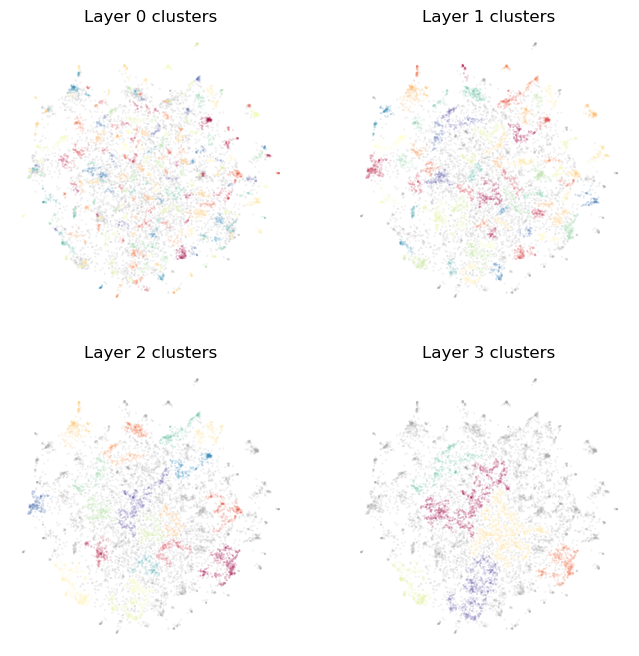

In [10]:
plot_cluster_layers(topic_model.cluster_layers_)

## Keyphrases

Having extracted clusters from the vectors we also need to extract keyphrases from actual documents. If your objects are not text based this is where the ``object_to_text_function`` would be used to generate text from which keyphrases can be extracted (and indeed there are tricks to ensure that not all the objects are converted to text in these cases, just a suitable representative sampling). Since we have text in the form of paper titles for our objects we can run the keyphrase builder directly on the objects.The task of the keyphrase builder is not to create suitable keyphrases for each cluster, but rather to pick apart the corpus as a whole (or some representative sample of it) and extract out *candidate* keyphrases that might be useful, and note which documents they occur in.

That means that the output of the keyphrase builder is simply a list of all the possible keyphrases we might use, and a large sparse matrix noting which keyphrases occur (and how often they occur) in each of the objects. Here we will stick with standard options, but there is an entire tutorial on keyphrase builders and how they work if you want to dig in further.

In [11]:
topic_model.keyphrase_builder.fit(arxiv_ct_df["title"])
topic_model.keyphrase_list_ = topic_model.keyphrase_builder.keyphrase_list_
topic_model.object_x_keyphrase_matrix_ = topic_model.keyphrase_builder.object_x_keyphrase_matrix_
topic_model.keyphrase_list_[:10], topic_model.object_x_keyphrase_matrix_

Building keyphrase matrix ... 
Chunking into 1 chunks of size 20000 for keyphrase identification.
Combining count dictionaries ...
Found 7493 keyphrases.
Chunking into 1 chunks of size 20000 for keyphrase count construction.
Combining count matrix chunks ...


(['categories',
  'theory',
  'category',
  'algebras',
  'homotopy',
  'categorical',
  'functors',
  'monoidal',
  'structures',
  'model'],
 <Compressed Sparse Row sparse matrix of dtype 'int32'
 	with 54529 stored elements and shape (8457, 7493)>)

As we said, what we get out is a list of keyphrases (here we are just looking at the top 10) and a large sparse matrix. As with the clusterer as need to ensure they get copied to where the usual fit method will store results for later use.

Now that we have all our candidates for keyphrases we can start applying keyphrases to clusters and finding good keyphrases that can help summarise a cluster. Because we are following the process that Toponymy uses we are just going to do this for the bottom layer of the most fine-grained clusters for now, rather than all the clusters at all the layers. To actually pick out good representative keyphrases we will need a few things: the actual keyphrases, the sparse matrix of where and how often the keyphrases appear in our documents, and vector representations of the keyphrases. The first two are obviously what the keyphrase builder built for us, and are clearly relevant, but why do we need vector representations? We want to ensure diversity among keyphrases, and that they represent ideas central to the cluster -- to do that we need to be able to make semantic comparisons between keyphrases. Since the keyphrases are only being compared amongst each other the keyphrase embeddings don't need to match the document embeddings, so we can potentially use an entirely different embedding model (as we are about to).

Internally Toponymy is going to look at an information weighted occurrence rates of keyphrases per cluster. What is the "information weighting"? It is a weighting determined by the information gained by knowing the distribution of a given keyphrase over documents compared to a baseline expected distribution. You can think of it as a more theoretically grounded version of class-based TF-IDF; it will pick out keyphrases that are most distinctive or distinguishing of a given cluster based on their relative distributions over clusters and over documents. Having selected the most distinguishing keyphrases Toponymy then uses the embedding vectors to ensure a diversity of keyphrases are ultimately selected.

Each cluster layer object keeps track of relevant information about the clusters in the layer, and provides a simple ``make_keyphrases`` method that handles all of this.

In [12]:
keyphrase_vectors = embedding_model.encode(topic_model.keyphrase_list_, show_progress_bar=True)
topic_model.cluster_layers_[0].make_keyphrases(topic_model.keyphrase_list_, topic_model.object_x_keyphrase_matrix_, keyphrase_vectors=keyphrase_vectors);
topic_model.cluster_layers_[0].keyphrases[0]

Batches:   0%|          | 0/235 [00:00<?, ?it/s]

Generating informative keyphrases:   0%|          | 0/226 [00:00<?, ?cluster/s]

['bundle gerbes',
 '2-gerbes',
 'non-abelian gerbes',
 'stacks and gerbes',
 'differential geometry of gerbes',
 '2-hilbert space',
 'introducing',
 'prequantum',
 'tame',
 'dixmier-douady',
 'symbols',
 'combinatorics',
 'holonomy',
 'tate',
 'characteristic classes',
 'weyl']

This process can take a little while as we need to embed they keyphrases. The result, however, is quite effective -- just looking at the keyphrases for one cluster we see informative keyphrases that, while clearly on a main topic ([gerbes](https://en.wikipedia.org/wiki/Gerbe), which are stacks of groupoids over topological spaces or sites), also have reasonable diversity and aren't merely near duplicates of each other. Even things that, perhaps, seem less relevant, such as ``'dixmier-douady'`` from [Dixmier-Douady classes](https://ncatlab.org/nlab/show/Dixmier-Douady+class), are very much on topic.

## Exemplars

In an ideal world, with ideally powerful LLMs, we wouldn't bother with keyphrases; we would just hand the LLM all the documents in the cluster, and let it sort out the best name. In practice clusters are large, documents can be long, and even though LLMs have very long context windows now, that does not mean they can use them to full effect. And that says nothing of the cost in compute (or money if you are using a service) of having the LLM chew through all of those tokens for every cluster. So rather than dumping everything into the LLM it is much better to provide just the *most relevant* information. Keyphrases are a very powerful way of doing that; but we can do more. While we can't provide all the document in a cluster to an LLM we can provide a small sampling or objects that will best represent the content of the cluster. The are the *exemplars* for the cluster. If we are dealing with a text corpus then simply selecting exemplar objects of the cluster will suffice; if we are working with, say, images, then generating a text description of exemplars (via an ``object_to_text_function``) will also work.

As with the keyphrases for each cluster, the cluster layers have a ``make_exemplar_texts`` method that handles this.

In [13]:
topic_model.cluster_layers_[0].make_exemplar_texts(arxiv_ct_df["title"], embedding_vectors);
topic_model.cluster_layers_[0].exemplars[0]

Selecting central exemplars:   0%|          | 0/226 [00:00<?, ?cluster/s]

['Equivariant bundle gerbes',
 'More Morphisms between Bundle Gerbes',
 'Notes on 1- and 2-gerbes',
 'Differential Geometry of Gerbes',
 'Central Extensions of Gerbes',
 'Four Equivalent Versions of Non-Abelian Gerbes',
 '2-gerbes and 2-Tate spaces',
 'On two notions of a Gerbe over a stack']

Looking at exemplars for one cluster we see we have successfully picked out a good selection of paper titles that, while circling a clear central topic, cover some of the diversity contained therein. Since we are still in the fine-grained clusters we can look at all the titles in the cluster to see that we have, indeed, gotten a reasonable selection.

In [14]:
arxiv_ct_df["title"][topic_model.cluster_layers_[0].cluster_labels == 0].tolist()

['2-gerbes and 2-Tate spaces',
 'Central Extensions of Gerbes',
 'G-gerbes, principal 2-group bundles and characteristic classes',
 'Differential Geometry of Gerbes and Differential Forms',
 'Differentiable Categories, gerbes and G-structures',
 'Connections on non-abelian Gerbes and their Holonomy',
 'Gerbes for the Chow',
 'Sato Grassmannians for generalized Tate spaces',
 'Four Equivalent Versions of Non-Abelian Gerbes',
 'Infinitesimal Symmetries of Dixmier-Douady Gerbes',
 'Equivariant bundle gerbes',
 'Smooth loop stacks of differentiable stacks and gerbes',
 'The 2-Hilbert Space of a Prequantum Bundle Gerbe',
 'Fluxes, bundle gerbes and 2-Hilbert spaces',
 'Gerbes over posets and twisted C*-dynamical systems',
 'Categorical Structures on Bundle Gerbes and Higher Geometric   Prequantisation',
 'On two notions of a Gerbe over a stack',
 'Bundle gerbes and the Weyl map',
 'Pontrjagin duality on multiplicative Gerbes',
 'Rigid models for 2-gerbes I: Chern-Simons geometry',
 'Combina

Later, when we move to higher cluster layers, where clusters can have thousands of documents in them, being able to pick out a core representative set of eight examples will be increasingly important.

## Prompts

Now that we've extracted a minimal set of relevant pieces of information about a cluster, we can start putting that together to get useful responses out of an LLM. Toponymy has built in templates to take the information provided and construct prompts for LLMs to extract out good names for clusters. The default templates work well, but it is possible to substitute your own -- just know that a lot of information is passed to the templates, so you will need to study the existing templates in order alternative replacements.

To make use of the templates to construct prompts each layer comes with a ``make_prompts`` method that will do the work. This takes a few parameters including a ``detail_level``, the current list of topic names per layer (here we'll; just provide an empty list of lists since we have no topic names yet), and object description, a corpus description, and a cluster_tree. We won't be making use of the cluster tree here, but other layers will. Most of this is self explanatory, except, perhaps, the detail level. This is a numeric value between 0.0 (for most detailed) and 1.0 (for most succinct) that is used to guide the LLM to provide cluster names with the right level of specificity. Since we are at the lowest layer and we have a fairly specific topic (category theory) to start with, we'll want a detail level of 0.0. If you have custom prompt templates, here is where you would pass them in with the ``prompt_template`` keyword argument -- see the tutorial on prompt templates for more detail on that.

Since we are using an LLM that supports system prompts, the result will be a dictionary with two keys ``"system"`` and ``"user"`` for the system and user prompts that will be passed to the LLM. If you are using Toponymy at a high level, or even a medium level, you don't need to worry about this, since the LLMWrappers can deal with prompts in this format, and will "do the right thing" which you hand it a single prompt string, or a dictionary like this. For our purposes, to see what is going on, it will help to unpack these and look at the system prompt and user prompt that get created for at least one cluster.

In [15]:
topic_model.cluster_layers_[0].make_prompts(
    detail_level=0.0,
    all_topic_names=[[]], # We have none yet
    object_description=topic_model.object_description,
    corpus_description=topic_model.corpus_description,
    cluster_tree=topic_model.cluster_tree_,
);
print("### System prompt:\n", topic_model.cluster_layers_[0].prompts[0]["system"])
print("\n\n### User prompt:\n", topic_model.cluster_layers_[0].prompts[0]["user"])

Generating prompts for layer 0:   0%|          | 0/226 [00:00<?, ?topic/s]

### System prompt:
 
You are an expert at classifying paper titles from category theory related papers into topics.
Your task is to analyze information about a group of paper titles and assign a domain expert level (8 to 15 word) name to this group.
The response must be in JSON formatted as {"topic_name":<NAME>, "topic_specificity":<SCORE>}
where NAME is the topic name you generate and SCORE is a float value between 0.0 and 1.0,
representing how specific and well-defined the topic name is given the input information.
A score of 1.0 means a perfectly descriptive and specific name, while 0.0 would be a completely generic or unrelated name.


Ensure your entire response is only the JSON object, with no other text before or after it.


### User prompt:
 
Here is the information about the group of paper titles:

- Keywords for this group include: bundle gerbes, 2-gerbes, non-abelian gerbes, stacks and gerbes, differential geometry of gerbes, 2-hilbert space, introducing, prequantum, tame, d

So we have a system prompt that sets up the context -- what kinds of objects are being modeled, the nature of the collection they are drawn from -- and provides instructions on the task and output format. That means that the user prompt just contains information about a given cluster. The information here amounts to the extracted keywords, and the exemplars of the cluster. You can also see, in the second to last sentence, that the ``detail_level`` has been translated into instructions for the kind of topic name to be provided. Each and every cluster will have its own prompt like this.

## Naming base layer topics

With a prompt set up for every cluster, the next step is going to be using an LLM to name the clusters. It turns out that this is a little more subtle than one imagine at first. Let's have a look at what the actual ``name_topics`` method actually does:

In [16]:
topic_model.cluster_layers_[0].name_topics??

Signature:
topic_model.cluster_layers_[0].name_topics(
    llm,
    detail_level: float,
    all_topic_names: List[List[str]],
    object_description: str,
    corpus_description: str,
    cluster_tree: Optional[dict] = None,
    embedding_model: Optional[sentence_transformers.SentenceTransformer.SentenceTransformer] = None,
) -> List[str]
Docstring: <no docstring>
Source:   
    def name_topics(
        self,
        llm,
        detail_level: float,
        all_topic_names: List[List[str]],
        object_description: str,
        corpus_description: str,
        cluster_tree: Optional[dict] = None,
        embedding_model: Optional[SentenceTransformer] = None,
    ) -> List[str]:
        self.topic_names = [
            (
                llm.generate_topic_name(prompt)
                if isinstance(prompt, dict) or not prompt.startswith("[!SKIP!]: ")
                else prompt.removeprefix("[!SKIP!]: ")
            )
            for prompt in tqdm(
                self.prompts,
   

So there are a few things going on here. First of all we have a loop in a list comprehension that generates the topic names, but it has an odd clause:

```python
    if isinstance(prompt, dict) or not prompt.startswith("[!SKIP!]: ")
    else prompt.removeprefix("[!SKIP!]: ")
```

This is not relevant yet, but for other layers it will start to matter. In some cases a cluster at one layer is essentially identical to a cluster below. When that happens we can generate a special prompt that skips the LLM and just re-uses the name given in the lower layer. We'll reproduce that logic here for consistency.

The more interesting aspect is that after having generated the topic names we then have a further call that "disambiguates" the topic names, followed by some further fallback logic that tries to catch anything that went wrong along the way. Since the disambiguation step is important, and worth going into some detail on, but will get swept under the carpet if we just call ``name_topics`` let's step through these stages individually and look at what is happening as we go.

First of all let's generate topic names with the list comprehension, and save them off within the topic model object:

In [17]:
topic_model.cluster_layers_[0].topic_names = [
    (
        topic_model.llm_wrapper.generate_topic_name(prompt)
        if isinstance(prompt, dict) or not prompt.startswith("[!SKIP!]: ")
        else prompt.removeprefix("[!SKIP!]: ")
    )
    for prompt in topic_model.cluster_layers_[0].prompts
]
topic_model.topic_names_ = [topic_model.cluster_layers_[0].topic_names, []]
topic_model.topic_names_[0][0]

'Gerbe Theory and Applications'

As you can see we actually get reasonably good and specific topic names out as long as you use a reasonably powerful LLM. Now that we have all the topic names for the layer, let's have a look at why we might want to "disambiguate" topic names. We can start by looking at the counts of occurences of topic names within the layer.

In [18]:
Counter(topic_model.topic_names_[0]).most_common(10)

[('Advanced Category Theory Topics', 3),
 ('Category Theory: Advanced Topics and Applications', 2),
 ('Gerbe Theory and Applications', 1),
 ('Ann-Category Theory and Applications', 1),
 ('Quiver Representations and Categories', 1),
 ('Euler Characteristic and Zeta Functions in Category Theory', 1),
 ('French Category Theory Research', 1),
 ('Mobius Inversion and Categorification', 1),
 ('Sheaf Theory and Applications', 1),
 ('Quasi-Coherent Sheaves and Derived Categories', 1)]

We see we have some duplicated topic names -- specifically topic names that were relatively generic given the corpus we are working with. It is almost certain that "Advanced Category Theory Topics" is a reasonable description of the papers in those clusters, but it is also not a useful description for our purposes here. What we care about is what differentiates these clusters from each other. Of course the LLM was not provided with information about the other clusters, so it cannot constrast them. So perhaps we should, at this point, make an effort to provide the LLM with that information so it can disambiguate those topics? Just looking at exactly duplicated topic names may not quite be sufficient of course. Depending on the LLM changes of case or captilaisation, spacing, or subtle word changes may prevent exact duplicates, but still result in almost identical topic names. The solution, given the tools we have at hand, is to find semantically similar topic names using text embeddings. This is built into Toponymy with a clustering function specifically designed for this use case. We can deploy it here and see what sets of potentially overly similar topic names we get out. 

In [19]:
from toponymy.cluster_layer import cluster_topic_names_for_renaming
from pprint import pprint

clusters_of_similar_topics, cluster_labels = (
    cluster_topic_names_for_renaming(topic_model.topic_names_[0], embedding_model=embedding_model)
)
for cluster in clusters_of_similar_topics:
    pprint([topic_model.topic_names_[0][x] for x in np.where(cluster_labels == cluster)[0]])

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

['Algebraic Structures and Their Extensions',
 'Abstract Algebraic Structures and Their Properties']
['Categorical Structures and Their Traces',
 'Categorical Traces and Implications']
['Categorical Structures in Algebraic Geometry',
 'Categorical Methods in Algebraic Geometry']
['Monads and Their Applications in Category Theory',
 'Monads and 2-Category Theory']
['Categorical Properties and Definitions',
 'Categorical Structures and Properties']
['Braided Monoidal Category Theory', 'Braided Category Theory']
['Factorization Systems and Categories',
 'Factorization Systems and Category Theory']
['Advanced Infinity Category Theory',
 'Advanced Topics in Infinity Category Theory']
['Category Theory: Advanced Topics and Applications',
 'Category Theory Applications and Fundamentals',
 'Advanced Category Theory and Applications',
 'Category Theory: Advanced Topics and Applications']
['Tensor Triangulated Category Theory', 'Triangulated Category Theory']
['Advanced Topos Theory and Applicat

We see that this picks up the exact duplicates, but also some near duplicates, and a couple of categories that perhaps are sufficiently differentiated, but that the text-embedding model still finds to be close. The ``disambiguate_topics`` function will run exactly this clustering, generate prompts designed to disambiguate among the topics in each cluster, then pass those through to the LLM and update the topic names accordingly.

In [20]:
topic_model.cluster_layers_[0].disambiguate_topics(
    llm=topic_model.llm_wrapper,
    detail_level=0.0,
    all_topic_names=topic_model.topic_names_,
    object_description=topic_model.object_description,
    corpus_description=topic_model.corpus_description,
    cluster_tree=topic_model.cluster_tree_,
    embedding_model=topic_model.embedding_model,
)

Generating disambiguation prompts for layer 0:   0%|          | 0/13 [00:00<?, ?topic-cluster/s]

Generating new disambiguated topics names for layer 0:   0%|          | 0/13 [00:00<?, ?topic-cluster/s]

Let's check that we managed to eliminate those duplicated topics:

In [21]:
Counter(topic_model.topic_names_[0]).most_common(10)

[('Gerbe Theory and Applications', 1),
 ('Ann-Category Theory and Applications', 1),
 ('Quiver Representations and Categories', 1),
 ('Euler Characteristic and Zeta Functions in Category Theory', 1),
 ('French Category Theory Research', 1),
 ('Mobius Inversion and Categorification', 1),
 ('Sheaf Theory and Applications', 1),
 ('Quasi-Coherent Sheaves and Derived Categories', 1),
 ('Cospan and Double Category Theory', 1),
 ('Frobenius-Schur Indicators in Category Theory', 1)]

So what was done to disambiguate between the topics? We can pull out the prompts used for disambiguation:

In [22]:
print("### System prompt:\n", topic_model.cluster_layers_[0].disambiguation_prompts[0]["system"])
print("\n\n### User prompt:\n", topic_model.cluster_layers_[0].disambiguation_prompts[0]["user"])

### System prompt:
 
You are an expert in Algebraic Structures and Their Extensions and Abstract Algebraic Structures and Their Properties. You have been asked to provide more specific and distinguishing names for various groups of
paper titles from category theory related papers that have been assigned overly similar auto-generated topic names.

Your task is to generate a new domain expert level (8 to 15 word) name for each topic group presented.
You should make use of the relative relationships between these topics, their keywords, subtopic information, and sample paper titles to generate new, distinct topic names.
The new names must be in the same order as the original topics are presented.
There should be no duplicate topic names in your final list of new names.




The response must be formatted as a single JSON object in the format:
{"new_topic_name_mapping": {"1. OLD_NAME1": "NEW_NAME1", "2. OLD_NAME2": "NEW_NAME2", ... }, "topic_specificities": [NEW_TOPIC_SCORE1, NEW_TOPIC_SCOR

We see that the LLM is given a different system prompt, instructing it that it is an expert in this particular field, and asking it to generate new topic names for a set of topics that were given overly similar names. The user prompt then provides the the same information as our original prompt, but this time it provides it for all of the candidate topics in the cluster of similarly named topics -- so now the LLM can compare and contrast among the specific topics that need to be differentiated.

We can see the results by looking at the names of the topics in the clusters we found earlier, but now with those updated names.

In [23]:
for cluster in clusters_of_similar_topics:
    pprint([topic_model.topic_names_[0][x] for x in np.where(cluster_labels == cluster)[0]])

['Higher Coverings and Extensions in Algebraic Structures',
 'Abstract Structures: Commutativity, Normality, and Enrichment']
['Bicategorical Shadows and Cotraces', 'Nonlinear and Physical Traces']
['Categorical Algebraic Structures and Toposes',
 'Categorical Methods for Differential Geometry']
['Monads: Theory, Semirings, and Applications',
 'Monads and 2-Category Theory: Universal Properties and Dualities']
['Categorical Definitions and Semi-Abelian Properties',
 'Categorical Structures and Injectivity Properties']
['Braided Monoidal Structures and Applications',
 'Braided Categorical Algebras and Crossed Modules']
['Factorization Categories and Functors',
 'Weak Factorization Systems and Orthogonality']
['Higher-Order Infinity Categories and Theory',
 'Advanced Topics in Non-Commutative Infinity Categories']
['Category Automorphisms and Cohomology',
 'Category Theory in Modeling and Ontology',
 'Higher Categories and Computational Methods',
 'Presheaves and Model Structures']
['Ten

We see that the LLM did a reasonably good job at picking apart the important aspects of each topic that differentiate if from the other topics in the same cluster.

## Moving up a layer

We have successfully named all the clusters in the bottom-most clustering layer. Now it is time to move up a layer. In principle we could simply repeat the same process. In practice, as we move up layers, things become more challenging. As topics become larger and slightly more general, our ability to provide enough information to name them well is limited. For the fine-grained layer the selection of exemplars largely covered all the content in the cluster. With larger clusters there is more variety within the cluster, and exemplar selection will be less representative. While it may not be too bad for the next layer, it is going to get increasingly problematic as we move up, so we are going to need a method to tackle this.

The trick we are going to use is the cluster tree -- higher layer clusters contain clusters from lower layers. We can use the names assigned to those sub-clusters to help summarise the cluster. Where possible we want to use the highest level sub-topic that we can, but it can also be useful to provide a selection of fine grained sub-topics of the cluster in question. For this we can proceed similarly to the exemplar and keyphrase selection -- picking out a set of bottom-layer subtopics that provide a good representative sampling of the subtopics of the cluster. Much as we did with the keyphrases we will make use of an embedding model to make it easier to compare and select among the subtopic names.

In [24]:
topic_model.cluster_layers_[1].make_exemplar_texts(arxiv_ct_df["title"], embedding_vectors);
topic_model.cluster_layers_[1].make_keyphrases(
    topic_model.keyphrase_list_, 
    topic_model.object_x_keyphrase_matrix_, 
    keyphrase_vectors=keyphrase_vectors, 
    embedding_model=embedding_model
);
topic_model.cluster_layers_[1].make_subtopics(
    topic_model.topic_names_[0],
    topic_model.cluster_layers_[0].cluster_labels,
    topic_model.cluster_layers_[0].topic_name_embeddings,
    topic_model.embedding_model,
);
topic_model.cluster_layers_[1].subtopics[0]

Selecting central exemplars:   0%|          | 0/71 [00:00<?, ?cluster/s]

Generating informative keyphrases:   0%|          | 0/71 [00:00<?, ?cluster/s]

Selecting central subtopics:   0%|          | 0/71 [00:00<?, ?cluster/s]

['Sheaf Theory and Applications',
 'Quasi-Coherent Sheaves and Derived Categories']

Now we can set about making the prompts. We need to increase the detail level to be less low-level so that we get more general topic names. At this stage we also see why we need to pass in the ``cluster_tree``: so we can pick out the major sub-topics of the cluster. We can run ``make_prompts`` for this layer and look at one of the prompts we get out:

In [25]:
topic_model.cluster_layers_[1].make_prompts(
    detail_level=0.33,
    all_topic_names=topic_model.topic_names_,
    object_description=topic_model.object_description,
    corpus_description=topic_model.corpus_description,
    cluster_tree=topic_model.cluster_tree_,
);
print("### System prompt:\n", topic_model.cluster_layers_[1].prompts[0]["system"])
print("\n\n### User prompt:\n", topic_model.cluster_layers_[1].prompts[0]["user"])

Generating prompts for layer 1:   0%|          | 0/71 [00:00<?, ?topic/s]

### System prompt:
 
You are an expert at classifying paper titles from category theory related papers into topics.
Your task is to analyze information about a group of paper titles and assign a specific and detailed (4 to 8 word) name to this group.
The response must be in JSON formatted as {"topic_name":<NAME>, "topic_specificity":<SCORE>}
where NAME is the topic name you generate and SCORE is a float value between 0.0 and 1.0,
representing how specific and well-defined the topic name is given the input information.
A score of 1.0 means a perfectly descriptive and specific name, while 0.0 would be a completely generic or unrelated name.


You should primarily make use of the major and minor subtopics of this group to generate a name,
and ensure the topic name reflects the core essence of *all* major subtopics.

Ensure your entire response is only the JSON object, with no other text before or after it.


### User prompt:
 
Here is the information about the group of paper titles:

- Ke

We have prompts similar to before, but are asking for a slightly less specific topic name (based on the detail level) and we now also include "Major subtopics of this group". Note that in this case the "Major subtopics" are identical to the selected exemplar subtopics (because there were, in fact, only two subtopics of this cluster at any layer level). As we move to higher layers that will cease to be the case.

We can now run ``name_topics`` for this layer, this time with the ``[!SKIP!]`` instruction potentially coming into play.

In [26]:
topic_model.cluster_layers_[1].topic_names = [
    (
        topic_model.llm_wrapper.generate_topic_name(prompt)
        if isinstance(prompt, dict) or not prompt.startswith("[!SKIP!]: ")
        else prompt.removeprefix("[!SKIP!]: ")
    )
    for prompt in topic_model.cluster_layers_[1].prompts
]
topic_model.topic_names_ = [topic_model.cluster_layers_[0].topic_names, topic_model.cluster_layers_[1].topic_names, []]
topic_model.topic_names_[1][0]

'Sheaf Theory and Derived Categories'

Great, we have some decent looking topic names. Let's check for duplicates as we did before:

In [27]:
Counter(topic_model.topic_names_[1]).most_common(10)

[('Sheaf Theory and Derived Categories', 1),
 ('Quiver Representations and Categories', 1),
 ('Factorization Systems and Functors', 1),
 ('Fusion Category Classification', 1),
 ('Modular Category Theory and Applications', 1),
 ('Tensor Triangulation & Support Theories', 1),
 ('Tensor Category Theory and Applications', 1),
 ('Tannakian Categories and Duality', 1),
 ('Advanced Mackey Functor Theory', 1),
 ('Fibrations and Lifting Properties', 1)]

Since there are fewer clusters in this layer, and many of them are more distinct, we don't have any actual duplicate topic names this time. On the other hand we can still try clustering the topic names to see if there are some potentially overly similar topic names that we can still try to distinguish between:

In [28]:
clusters_of_similar_topics, cluster_labels = (
    cluster_topic_names_for_renaming(topic_model.topic_names_[1], embedding_model=embedding_model)
)
for cluster in clusters_of_similar_topics:
    pprint([topic_model.topic_names_[1][x] for x in np.where(cluster_labels == cluster)[0]])

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

['Categorical Quantum Theory Foundations',
 'Categorical Topological Quantum Field Theories']
['Quantale-Enriched Category Theory',
 'Enriched Category Theory and Applications']
['Category Theory Fundamentals', 'Advanced Category Theory Topics']
['Advanced Infinity Category Theory',
 'Higher-Order Infinity Categories and Theory']


There are definitely some near duplicates, and some topics that are distinct, but perhaps can benefit from being more directly contrasted with one another. Let's run ``disambiguate_topics`` for the layer and then check.

In [29]:
topic_model.cluster_layers_[1].disambiguate_topics(
    llm=topic_model.llm_wrapper,
    detail_level=0.33,
    all_topic_names=topic_model.topic_names_,
    object_description=topic_model.object_description,
    corpus_description=topic_model.corpus_description,
    cluster_tree=topic_model.cluster_tree_,
    embedding_model=topic_model.embedding_model,
)

Generating disambiguation prompts for layer 1:   0%|          | 0/4 [00:00<?, ?topic-cluster/s]

Generating new disambiguated topics names for layer 1:   0%|          | 0/4 [00:00<?, ?topic-cluster/s]

Now let's see what the new names of those topics are:

In [30]:
for cluster in clusters_of_similar_topics:
    pprint([topic_model.topic_names_[1][x] for x in np.where(cluster_labels == cluster)[0]])

['Categorical Quantum Foundations and Interpretations',
 'Categorical Topological Field Theories and Symmetries']
['Quantale-Enriched Category Dualities',
 'Enriched Category Theory: Cellularization']
['Category Theory: Basics and Applications',
 'Advanced Topics in Topological Categories']
['Advanced Non-Commutative Infinity Categories',
 'Higher-Order Infinity Category Theory and Models']


It looks like it did a decent job of differentiating them: even though the topics are somewhat similar the names now highlight what makes them different from one another.

## Higher level topics

Now that we have the general flow of the process we can go a little faster. The next layer up has larger clusters, with more subtopics, and at least two layers below it, so pulling out and using subtopics from those layers will be more important, and provide richer results. Let's go through the process here and generate the prompts for this layer:

In [31]:
topic_model.cluster_layers_[2].make_exemplar_texts(arxiv_ct_df["title"], embedding_vectors);
topic_model.cluster_layers_[2].make_keyphrases(
    topic_model.keyphrase_list_, 
    topic_model.object_x_keyphrase_matrix_, 
    keyphrase_vectors=keyphrase_vectors, 
    embedding_model=embedding_model
);
topic_model.cluster_layers_[2].make_subtopics(
    topic_model.topic_names_[0],
    topic_model.cluster_layers_[0].cluster_labels,
    topic_model.cluster_layers_[0].topic_name_embeddings,
    topic_model.embedding_model,
);
topic_model.cluster_layers_[2].make_prompts(
    detail_level=0.66,
    all_topic_names=topic_model.topic_names_,
    object_description=topic_model.object_description,
    corpus_description=topic_model.corpus_description,
    cluster_tree=topic_model.cluster_tree_,
);
print("### System prompt:\n", topic_model.cluster_layers_[2].prompts[0]["system"])
print("\n\n### User prompt:\n", topic_model.cluster_layers_[2].prompts[0]["user"])

Selecting central exemplars:   0%|          | 0/20 [00:00<?, ?cluster/s]

Generating informative keyphrases:   0%|          | 0/20 [00:00<?, ?cluster/s]

Selecting central subtopics:   0%|          | 0/20 [00:00<?, ?cluster/s]

Generating prompts for layer 2:   0%|          | 0/20 [00:00<?, ?topic/s]

### System prompt:
 
You are an expert at classifying paper titles from category theory related papers into topics.
Your task is to analyze information about a group of paper titles and assign a focussed and brief (2 to 5 word) name to this group.
The response must be in JSON formatted as {"topic_name":<NAME>, "topic_specificity":<SCORE>}
where NAME is the topic name you generate and SCORE is a float value between 0.0 and 1.0,
representing how specific and well-defined the topic name is given the input information.
A score of 1.0 means a perfectly descriptive and specific name, while 0.0 would be a completely generic or unrelated name.


You should primarily make use of the major and minor subtopics of this group to generate a name,
and ensure the topic name reflects the core essence of *all* major subtopics.

Ensure your entire response is only the JSON object, with no other text before or after it.


### User prompt:
 
Here is the information about the group of paper titles:

- Keywo

Looking at the one prompt, now that we have more layers and more papers in a cluster we get more topic information -- we have major sub-topics and also a list of detailed subtopics. Otherwise the prompt look essentially the same in form.

Let's run the loop to name all of the clusters.

In [32]:
topic_model.cluster_layers_[2].topic_names = [
    (
        topic_model.llm_wrapper.generate_topic_name(prompt)
        if isinstance(prompt, dict) or not prompt.startswith("[!SKIP!]: ")
        else prompt.removeprefix("[!SKIP!]: ")
    )
    for prompt in topic_model.cluster_layers_[2].prompts
]
topic_model.topic_names_ = [topic_model.cluster_layers_[0].topic_names, topic_model.cluster_layers_[1].topic_names, topic_model.cluster_layers_[2].topic_names, []]
topic_model.topic_names_[2][0]

'Tensor Category Theory'

We get a good brief name, reflecting the higher level topic we are at now. Let's check for any overly similar names -- much less likely now that we have fewer clusters.

In [33]:
clusters_of_similar_topics, cluster_labels = (
    cluster_topic_names_for_renaming(topic_model.topic_names_[2], embedding_model=embedding_model)
)
for cluster in clusters_of_similar_topics:
    pprint([topic_model.topic_names_[2][x] for x in np.where(cluster_labels == cluster)[0]])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Our clustering technique finds nothing that is sufficiently similar to worry about. And indeed, we don't have that many topic names to worry about anymore, so let's look at the full list:

In [34]:
topic_model.topic_names_[2]

['Tensor Category Theory',
 'Groupoid Structures and Applications',
 'Categorical Quantum Theories',
 'Cotorsion Pairs and Recollements',
 'Abelian Category Theory',
 'Functorial Constructions and Applications',
 'Homotopy Theory',
 'Monads, Adjunctions, and Applications',
 'Triangulated Category Theory',
 'Hopf Algebra Extensions',
 'Frobenius Category Theory',
 'Infinity Category Theory',
 'Categorical Set Theory',
 'Categorical Network Dynamics',
 'Categorical Logic and Semantics',
 'Categorical Duality Theories',
 'Monoidal Category Theory',
 'Enriched Category Theory',
 'Bicategories and Cartesian Structures',
 'Advanced Category Theory']

## Top level topics

We only have one layer left, so we can make use of all the topic names from the previous layers to inform topic naming for this layer, along with the usual keywords and exemplars. You should be familiar with the process by now, so we won't belabour it...

In [35]:
topic_model.cluster_layers_[3].make_exemplar_texts(arxiv_ct_df["title"], embedding_vectors);
topic_model.cluster_layers_[3].make_keyphrases(
    topic_model.keyphrase_list_, 
    topic_model.object_x_keyphrase_matrix_, 
    keyphrase_vectors=keyphrase_vectors, 
    embedding_model=embedding_model
);
topic_model.cluster_layers_[3].make_subtopics(
    topic_model.topic_names_[0],
    topic_model.cluster_layers_[0].cluster_labels,
    topic_model.cluster_layers_[0].topic_name_embeddings,
    topic_model.embedding_model,
);
topic_model.cluster_layers_[3].make_prompts(
    detail_level=0.8,
    all_topic_names=topic_model.topic_names_,
    object_description=topic_model.object_description,
    corpus_description=topic_model.corpus_description,
    cluster_tree=topic_model.cluster_tree_,
);

topic_model.cluster_layers_[3].topic_names = [
    (
        topic_model.llm_wrapper.generate_topic_name(prompt)
        if isinstance(prompt, dict) or not prompt.startswith("[!SKIP!]: ")
        else prompt.removeprefix("[!SKIP!]: ")
    )
    for prompt in topic_model.cluster_layers_[3].prompts
]
topic_model.topic_names_ = [topic_model.cluster_layers_[0].topic_names, topic_model.cluster_layers_[1].topic_names, topic_model.cluster_layers_[2].topic_names, topic_model.cluster_layers_[3].topic_names]
topic_model.topic_names_[3]

Selecting central exemplars:   0%|          | 0/6 [00:00<?, ?cluster/s]

Generating informative keyphrases:   0%|          | 0/6 [00:00<?, ?cluster/s]

Selecting central subtopics:   0%|          | 0/6 [00:00<?, ?cluster/s]

Generating prompts for layer 3:   0%|          | 0/6 [00:00<?, ?topic/s]

['Categorical Quantum Theories',
 'Homotopy Theory',
 'Frobenius Hopf Algebras',
 'Monoidal Categorical Dualities',
 'Categorical Theory',
 'Advanced Categorical Structures']

We get a good set of high level topics out, despite the fact that each of these clusters contains hundreds of documents.

And that is a walkthrough (at a relatively high level) of the internals of what goes on when you call ``fit`` on a Toponymy object. Of course all of this is automated for you if you just call ``fit`` and you can just evaluate the results, but it can be helpful to know what the actual process looks like.